## Motor erf HNN-modeling and optimization

Motor ERF from button press experiment -response time-locked, from Bonaiuto et al. 2018

HNN-core parameters optimization protocol from: https://jonescompneurolab.github.io/hnn-core

In [1]:
import os
import copy
from model_merf import set_params
from preprocessing import preprocess_erf
from run_optim import run_batch_optim
from hnn_core import read_dipole
from hnn_core import (law_2021_model, jones_2009_model)
from hnn_core import (read_dipole, simulate_dipole, MPIBackend, JoblibBackend)
from custom_optim import SequentialOptimizer
from hnn_core.dipole import (average_dipoles, plot_dipole)
from matplotlib import pyplot as plt

In [2]:
%env OMPI_TMPDIR=/scratch
%env TMPDIR=/scratch

env: OMPI_TMPDIR=/scratch
env: TMPDIR=/scratch


In [3]:
%env TMPDIR

'/scratch'

In [4]:
base_data_dir='/home/bonaiuto/laminar_csd/data'
subject='sub-001'
session='ses-01'
c_idx=3
epoch='motor'
data_dir=os.path.join(base_data_dir, subject, session, f'{subject}_{session}_c{c_idx}_{epoch}')
output_dir=os.path.join(data_dir, 'hnn_input')

hnn_dir=os.path.join(base_data_dir, subject, session, f'{subject}_{session}_c{c_idx}_{epoch}_hnn')

print(data_dir)

/home/bonaiuto/laminar_csd/data/sub-001/ses-01/sub-001_ses-01_c3_motor


#### Loading and preprocessing of the merfs
turn if inverted dipole

In [5]:
preprocess_erf(data_dir, output_dir, 600, 18)

Setting up low-pass filter at 18 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 18.00 Hz: -6.02 dB

Processed sub-001_ses-01_c3_motor. ERF was flipped. Filtered at 18 Saved to /home/bonaiuto/laminar_csd/data/sub-001/ses-01/sub-001_ses-01_c3_motor/hnn_input/sub-001_ses-01_c3_motor_erf.txt


In [6]:
exp_dpl = read_dipole(os.path.join(output_dir, f'{subject}_{session}_c{c_idx}_{epoch}_erf.txt'))

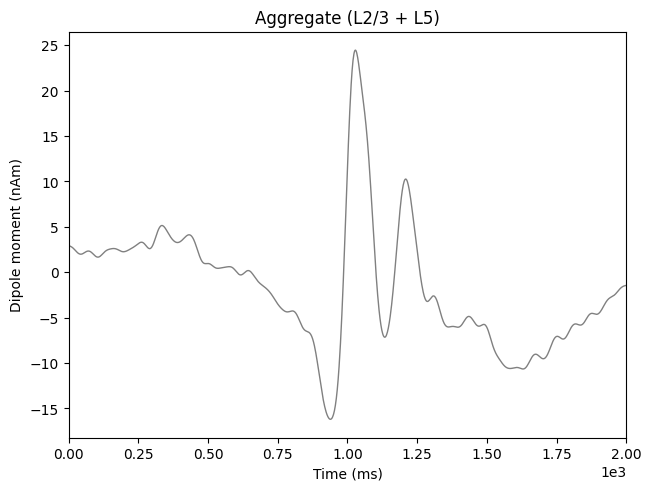

In [7]:
_ = exp_dpl.plot()

#### Optimization

In [8]:
constraints = dict({'evdist2_ampa_L2_basket': (0.01, 1.),
                    'evdist2_ampa_L2_pyramidal': (0.01, 1.),
                    'evdist2_ampa_L5_pyramidal': (0.01, 1.),
                    'evdist2_nmda_L2_basket': (0.01, 1.),
                    'evdist2_nmda_L2_pyramidal': (0.01, 1.),
                    'evdist2_nmda_L5_pyramidal': (0.01, 1.),
                    'evdist2_mu': (900., 970.),
                    'evdist2_sigma': (10., 40.),

                    'evprox1_ampa_L2_basket': (0.01, 1.),
                    'evprox1_ampa_L2_pyramidal': (0.01, 1.),
                    'evprox1_ampa_L5_basket': (0.01, 1.),
                    'evprox1_ampa_L5_pyramidal': (0.01, 1.),
                    'evprox1_nmda_L2_basket': (0.01, 1.),
                    'evprox1_nmda_L2_pyramidal': (0.01, 1.),
                    'evprox1_nmda_L5_basket': (0.01, 1.),
                    'evprox1_nmda_L5_pyramidal': (0.01, 1.),
                    'evprox1_mu': (1000., 1100.),
                    'evprox1_sigma': (2., 30.),

                    'evdist3_ampa_L2_basket': (0.01, 1.),
                    'evdist3_ampa_L2_pyramidal': (0.01, 1.),
                    'evdist3_ampa_L5_pyramidal': (0.01, 1.),
                    'evdist3_nmda_L2_basket': (0.01, 1.),
                    'evdist3_nmda_L2_pyramidal': (0.01, 1.),
                    'evdist3_nmda_L5_pyramidal': (0.01, 1.),
                    'evdist3_mu': (1100., 1200.),
                    'evdist3_sigma': (10., 40.)
                   })

In [9]:
import json
with open('initial_params.json', 'r') as f:
    initial_params = json.load(f)

In [10]:
initial_params={'evdist2_ampa_L2_basket': 0.05,
 'evdist2_ampa_L2_pyramidal': 0.2,
 'evdist2_ampa_L5_pyramidal': 0.1,
 'evdist2_nmda_L2_basket': 0.02,
 'evdist2_nmda_L2_pyramidal': 0.1,
 'evdist2_nmda_L5_pyramidal': 0.3,
 'evdist2_mu': 935,
 'evdist2_sigma': 30,
 'evprox1_ampa_L2_basket': 0.3,
 'evprox1_ampa_L2_pyramidal': 0.8,
 'evprox1_ampa_L5_basket': 0.3,
 'evprox1_ampa_L5_pyramidal': 1.0,
 'evprox1_nmda_L2_basket': 0.7,
 'evprox1_nmda_L2_pyramidal': 0.15,
 'evprox1_nmda_L5_basket': 0.6,
 'evprox1_nmda_L5_pyramidal': 0.38,
 'evprox1_mu': 1025,
 'evprox1_sigma': 30,
 'evdist3_ampa_L2_basket': 0.02,
 'evdist3_ampa_L2_pyramidal': 0.2,
 'evdist3_ampa_L5_pyramidal': 0.1,
 'evdist3_nmda_L2_basket': 0.01,
 'evdist3_nmda_L2_pyramidal': 0.08,
 'evdist3_nmda_L5_pyramidal': 0.1,
 'evdist3_mu': 1120,
 'evdist3_sigma': 30}

In [11]:
n_trials = 10
tstop = 2000
window_len, scaling_factor = 30, 1250 #estimated 250,000 cells

net = law_2021_model(None)
net = set_params(net, initial_params)

with MPIBackend(n_procs=50, mpi_cmd='mpiexec'):
#with JoblibBackend(n_jobs=50):
    init_dpl = simulate_dipole(net, tstop=tstop, n_trials=n_trials)

for dpl in init_dpl:
    dpl.smooth(window_len).scale(scaling_factor)

avg_dpl_init = average_dipoles(init_dpl)

Setting parameters: {'evdist2_ampa_L2_basket': 0.05, 'evdist2_ampa_L2_pyramidal': 0.2, 'evdist2_ampa_L5_pyramidal': 0.1, 'evdist2_nmda_L2_basket': 0.02, 'evdist2_nmda_L2_pyramidal': 0.1, 'evdist2_nmda_L5_pyramidal': 0.3, 'evdist2_mu': 935, 'evdist2_sigma': 30, 'evprox1_ampa_L2_basket': 0.3, 'evprox1_ampa_L2_pyramidal': 0.8, 'evprox1_ampa_L5_basket': 0.3, 'evprox1_ampa_L5_pyramidal': 1.0, 'evprox1_nmda_L2_basket': 0.7, 'evprox1_nmda_L2_pyramidal': 0.15, 'evprox1_nmda_L5_basket': 0.6, 'evprox1_nmda_L5_pyramidal': 0.38, 'evprox1_mu': 1025, 'evprox1_sigma': 30, 'evdist3_ampa_L2_basket': 0.02, 'evdist3_ampa_L2_pyramidal': 0.2, 'evdist3_ampa_L5_pyramidal': 0.1, 'evdist3_nmda_L2_basket': 0.01, 'evdist3_nmda_L2_pyramidal': 0.08, 'evdist3_nmda_L5_pyramidal': 0.1, 'evdist3_mu': 1120, 'evdist3_sigma': 30}


/home/bonaiuto/miniconda3/envs/hnn4/lib/python3.12/site-packages/hnn_core/parallel_backends.py:891: UserWarning: Number of requested MPI processes exceeds available cores. Enabling MPI oversubscription automatically.
  warn(


MPI will run 10 trial(s) sequentially by distributing network neurons over 50 processes.
/home/bonaiuto/miniconda3/envs/hnn4/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/home/bonaiuto/miniconda3/envs/hnn4/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/home/bonaiuto/miniconda3/envs/hnn4/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/home/bonaiuto/miniconda3/envs/hnn4/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/home/bonaiuto/miniconda3/envs/hnn4/bin/nrniv:10: DeprecationWarning: pkg_r

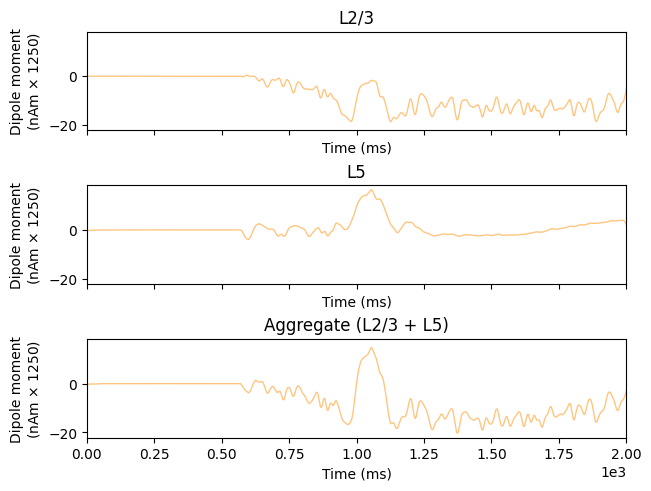

In [12]:
_=avg_dpl_init.plot(layer=['L2', 'L5', 'agg'],show=False, color='darkorange')

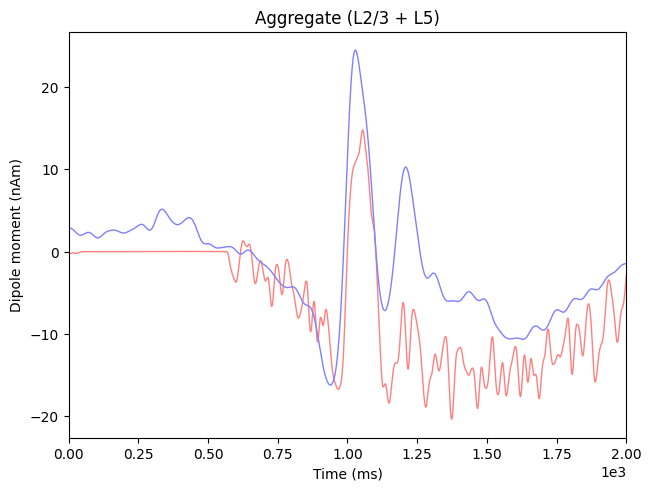

In [13]:
fig=avg_dpl_init.plot(layer=['agg'],show=False,color='red')
ax=plt.gca()
_ = exp_dpl.plot(ax=ax,color='blue')

Trial 9: 0.03 ms...
Trial 9: 10.0 ms...
Trial 9: 20.0 ms...
Trial 9: 30.0 ms...
Trial 9: 40.0 ms...
Trial 9: 50.0 ms...
Trial 9: 60.0 ms...
Trial 9: 70.0 ms...
Trial 9: 80.0 ms...
Trial 9: 90.0 ms...
Trial 9: 100.0 ms...
Trial 9: 110.0 ms...
Trial 9: 120.0 ms...
Trial 9: 130.0 ms...
Trial 9: 140.0 ms...
Trial 9: 150.0 ms...
Trial 9: 160.0 ms...
Trial 9: 170.0 ms...
Trial 9: 180.0 ms...
Trial 9: 190.0 ms...
Trial 9: 200.0 ms...
Trial 9: 210.0 ms...
Trial 9: 220.0 ms...
Trial 9: 230.0 ms...
Trial 9: 240.0 ms...
Trial 9: 250.0 ms...
Trial 9: 260.0 ms...
Trial 9: 270.0 ms...
Trial 9: 280.0 ms...
Trial 9: 290.0 ms...
Trial 9: 300.0 ms...
Trial 9: 310.0 ms...
Trial 9: 320.0 ms...
Trial 9: 330.0 ms...
Trial 9: 340.0 ms...
Trial 9: 350.0 ms...
Trial 9: 360.0 ms...
Trial 9: 370.0 ms...
Trial 9: 380.0 ms...
Trial 9: 390.0 ms...
Trial 9: 400.0 ms...
Trial 9: 410.0 ms...
Trial 9: 420.0 ms...
Trial 9: 430.0 ms...
Trial 9: 440.0 ms...
Trial 9: 450.0 ms...
Trial 9: 460.0 ms...
Trial 9: 470.0 ms...
Tr

/home/bonaiuto/laminar_csd/custom_optim.py:488: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show(show)


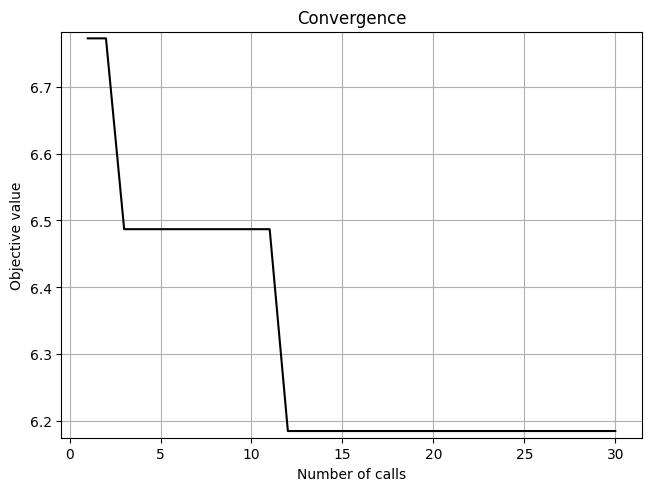

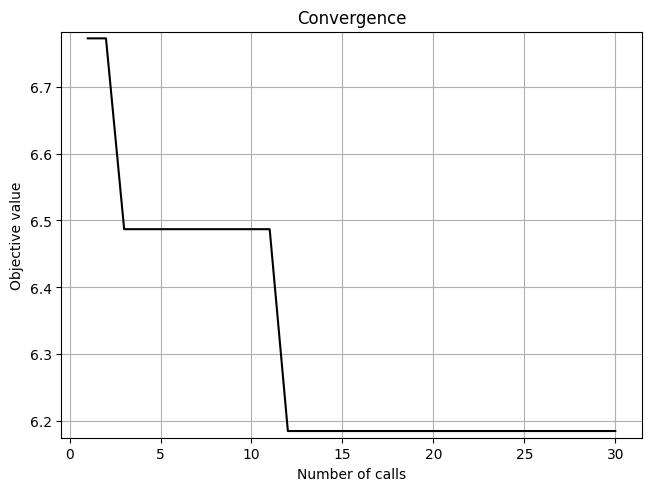

In [14]:
net=law_2021_model()
drives_to_optimize = ['evdist2', 'evprox1', 'evdist3']
optim = SequentialOptimizer(net, tstop, n_trials, constraints, set_params, solver='bayesian', max_iter_per_drive=10)
with MPIBackend(n_procs=50, mpi_cmd='mpiexec'):
    optim.fit(initial_params=initial_params, drives_to_optimize = drives_to_optimize,
              target=exp_dpl, scale_factor=scaling_factor, smooth_window_len=window_len)
opt_params = dict(zip(constraints.keys(), optim.opt_params_))
optim.plot_convergence()

#### Vizualization
First load the optimized dipole you want to plot

In [15]:
opt_params_fname = os.path.join(hnn_dir, f'{subject}_{session}_c{c_idx}_{epoch}_erf_opt_params.json')

In [16]:
with open(opt_params_fname, 'w') as f:
    json.dump(opt_params, f)

In [17]:
with open(opt_params_fname, 'r') as f:
    opt_params = json.load(f)

In [18]:
optim_net = law_2021_model()
optim_net = set_params(optim_net, opt_params)

Setting parameters: {'evdist2_ampa_L2_basket': 0.24835830561354402, 'evdist2_ampa_L2_pyramidal': 0.2350467438599327, 'evdist2_ampa_L5_pyramidal': 0.24908280173436617, 'evdist2_nmda_L2_basket': 0.5534423950668973, 'evdist2_nmda_L2_pyramidal': 0.1121530915911214, 'evdist2_nmda_L5_pyramidal': 0.0329964418967209, 'evdist2_mu': 939.6502269218001, 'evdist2_sigma': 12.903601741239173, 'evprox1_ampa_L2_basket': 0.10920206680436437, 'evprox1_ampa_L2_pyramidal': 0.21531304587194455, 'evprox1_ampa_L5_basket': 0.2012493295364233, 'evprox1_ampa_L5_pyramidal': 0.2959488249447399, 'evprox1_nmda_L2_basket': 0.991108731278414, 'evprox1_nmda_L2_pyramidal': 0.5597909596395656, 'evprox1_nmda_L5_basket': 0.3666480858640013, 'evprox1_nmda_L5_pyramidal': 0.6427178005880251, 'evprox1_mu': 1017.2183589419386, 'evprox1_sigma': 26.574367387643132, 'evdist3_ampa_L2_basket': 0.02, 'evdist3_ampa_L2_pyramidal': 0.2, 'evdist3_ampa_L5_pyramidal': 0.1, 'evdist3_nmda_L2_basket': 0.01, 'evdist3_nmda_L2_pyramidal': 0.08, 

In [19]:
with MPIBackend(n_procs=50, mpi_cmd='mpiexec'):
    opt_dpl = simulate_dipole(optim_net, tstop=tstop, n_trials=n_trials)

for dpl in opt_dpl:
    dpl.smooth(window_len).scale(scaling_factor)

avg_dpl_opt = average_dipoles(opt_dpl)

/home/bonaiuto/miniconda3/envs/hnn4/lib/python3.12/site-packages/hnn_core/parallel_backends.py:891: UserWarning: Number of requested MPI processes exceeds available cores. Enabling MPI oversubscription automatically.
  warn(


MPI will run 10 trial(s) sequentially by distributing network neurons over 50 processes.
/home/bonaiuto/miniconda3/envs/hnn4/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/home/bonaiuto/miniconda3/envs/hnn4/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/home/bonaiuto/miniconda3/envs/hnn4/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/home/bonaiuto/miniconda3/envs/hnn4/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/home/bonaiuto/miniconda3/envs/hnn4/bin/nrniv:10: DeprecationWarning: pkg_r

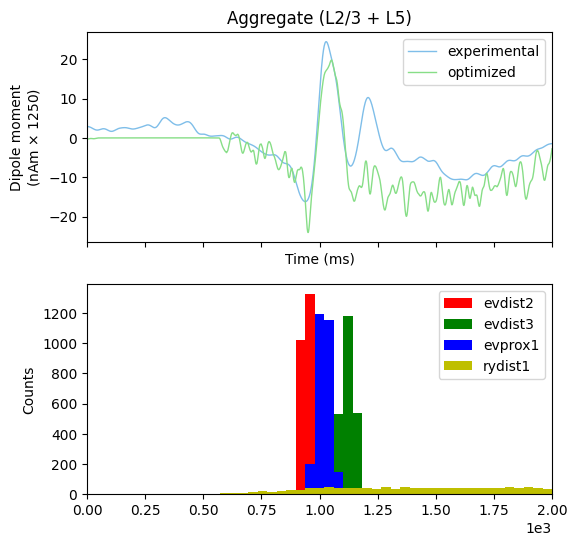

In [21]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6))

# plot original
exp_dpl.plot(ax=axes[0], layer='agg', show=False, color='tab:blue')
avg_dpl_opt.plot(ax=axes[0], layer='agg', show=False, color='tab:green')
axes[0].legend(['experimental','optimized'])
optim_net.cell_response.plot_spikes_hist(ax=axes[1])

plt.show()

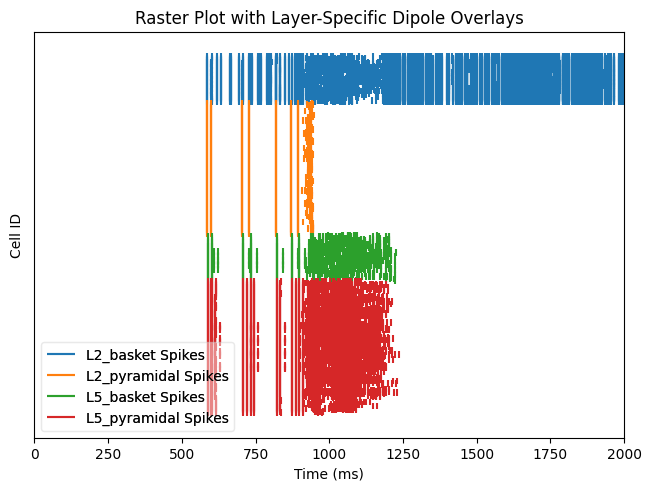

In [24]:
_ = optim_net.cell_response.plot_spikes_raster()

Laminar contributions

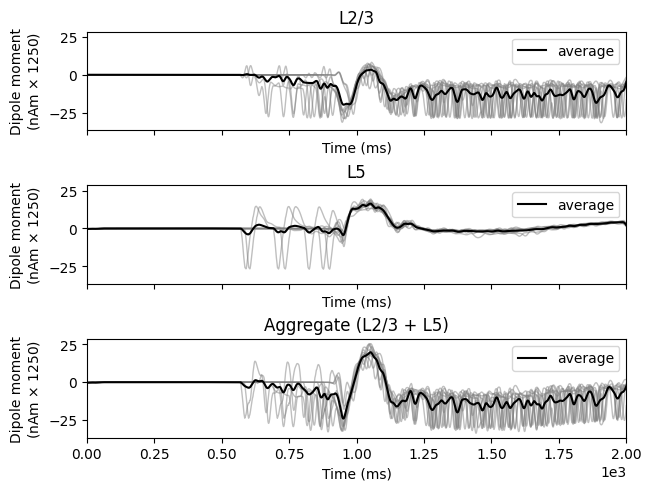

In [25]:
_ = plot_dipole(opt_dpl, average=True, layer=['L2', 'L5', 'agg'], show=False)